# Flower_Classification

In [4]:
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas  as pd 
import matplotlib.image as mpimg 

##Getting Dataset from kaggle

In [5]:
!pip install -q kaggle 

First expire the API token from account in kaggle and then create new token and `.json` file will be downloaded. Then upload `.json` file in colab. i.e in below cell 

In [6]:
# Choose the kaggle.json file that you downloaded
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"meltingrexmicrosoft","key":"1b5afac6280c77fca5c24e5ef4aedb67"}'}

In [7]:
!mkdir ~/.kaggle # Run if can't find this folder 

In [8]:
# Make directory named kaggle if needed else copy kaggle.json file there.
!cp kaggle.json ~/.kaggle/

In [9]:
# Change the permissions of the file.
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
# That's all ! You can check if everything's okay by running this command
!kaggle datasets list 

ref                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/piterfm/2022-ukraine-russian-war                      2022 Ukraine Russia War                            2KB  2022-04-20 07:52:05           9980        551  1.0              
datasets/muratkokludataset/date-fruit-datasets                 Date Fruit Datasets                              408KB  2022-04-03 09:25:39           1593        302  0.9375           
datasets/muratkokludataset/acoustic-extinguisher-fire-dataset  Acoustic Extinguisher Fire Dataset               621KB  2022-04-02 22:59:36            188        266  0.9375           
datasets/kamilpytlak/personal-key-indicators-of-heart-disease  Personal Key Indi

### Getting the data 

In [11]:
# Download the data 
!kaggle datasets download -d alxmamaev/flowers-recognition

 98% 220M/225M [00:05<00:00, 42.8MB/s]
100% 225M/225M [00:05<00:00, 45.2MB/s]


In [12]:
# Extract data
import zipfile
def unzip(filename):
  zip_ref = zipfile.ZipFile(filename , "r")
  zip_ref.extractall()
  zip_ref.close()

In [13]:
unzip("flowers-recognition.zip")

## Becoming One with data 

In [14]:
import os 
def check_folder(folder_name):
  for dir_path ,  dir_names ,file_names in os.walk(folder_name):
    print(f"There are {len(dir_names)} and {len(file_names)} images in directory: {dir_path}") 

In [15]:
check_folder("flowers")

There are 5 and 0 images in directory: flowers
There are 0 and 764 images in directory: flowers/daisy
There are 0 and 1052 images in directory: flowers/dandelion
There are 0 and 733 images in directory: flowers/sunflower
There are 0 and 784 images in directory: flowers/rose
There are 0 and 984 images in directory: flowers/tulip


## Create train and test folder 

In [16]:
!pip install split-folders
import splitfolders

In [17]:
input_folder = "flowers/"
splitfolders.ratio(input_folder , output="flower_split",
                  seed=42,
                  ratio=(.8,.2),
                   group_prefix=None)

Copying files: 4317 files [00:01, 2539.08 files/s]


In [18]:
train_dir = "/content/flower_split/train"
test_dir = "/content/flower_split/val"

In [19]:
check_folder(train_dir)

There are 5 and 0 images in directory: /content/flower_split/train
There are 0 and 611 images in directory: /content/flower_split/train/daisy
There are 0 and 841 images in directory: /content/flower_split/train/dandelion
There are 0 and 586 images in directory: /content/flower_split/train/sunflower
There are 0 and 627 images in directory: /content/flower_split/train/rose
There are 0 and 787 images in directory: /content/flower_split/train/tulip


In [20]:
check_folder(test_dir)

There are 5 and 0 images in directory: /content/flower_split/val
There are 0 and 153 images in directory: /content/flower_split/val/daisy
There are 0 and 211 images in directory: /content/flower_split/val/dandelion
There are 0 and 147 images in directory: /content/flower_split/val/sunflower
There are 0 and 157 images in directory: /content/flower_split/val/rose
There are 0 and 197 images in directory: /content/flower_split/val/tulip


## Create Train anad test data

In [21]:
import random 
def view_random_image(target_dir , target_class):
  target_folder = target_dir + "/" + target_class
  rand_img = random.sample(os.listdir(target_folder) , 1)
  img = mpimg.imread(target_folder + "/" + rand_img[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  print(f"Shape of image : {img.shape}")
  return img

Shape of image : (333, 500, 3)


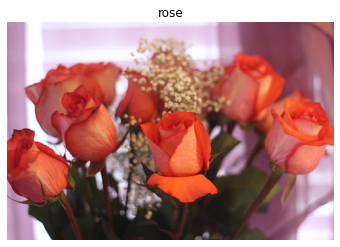

In [22]:
img = view_random_image(train_dir , "rose")

In [23]:
BATCH_SIZE=32
IMG_SIZE=(224,224)

In [24]:
train_data = tf.keras.utils.image_dataset_from_directory(train_dir, 
                                                          label_mode="categorical",
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE,
                                                          seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                        label_mode="categorical",
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE,
                                                        seed=42,
                                                        shuffle=False)

Found 3452 files belonging to 5 classes.
Found 865 files belonging to 5 classes.


In [25]:
class_names = train_data.class_names
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

## Preprocessing 

In [26]:
from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow.keras import Sequential 

### Data Augmentation Layer 

In [27]:
# set seed 
tf.random.set_seed(42)
Augmented_layer = Sequential([
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomZoom(0.2),
        preprocessing.RandomHeight(0.2),
        preprocessing.RandomWidth(0.2),                   
])

In [28]:
checkpoint_path = "Models_checkpoints"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path ,
                                                         save_best_only = True,
                                                         save_weights_only=True,
                                                         verbose=1)

In [29]:
import datetime
def create_tensorboard_callback(path , name):
  dir_path = path + "/" + name + "/" +  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback =  tf.keras.callbacks.TensorBoard(log_dir=dir_path)
  print(f"Saving tensorboard log files to {dir_path}")
  return tensorboard_callback

## Get the model from tensorflow hub 

In [30]:
efficient_b7 = "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1" 
resnet = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

## Modeling 

### Model_1 : `Efficient b7`

Without Data Augmentation 



In [31]:
initial_epochs =5

In [32]:
# Create the base model 
base_model = tf.keras.applications.EfficientNetB7(include_top=False)

# Freeze the base model (so pre_learned patterns remain)
base_model.trainable = False

# create inputs into the base model
inputs =tf.keras.layers.Input(shape=(224,224,3) ,name="input_layer")

# pass inputs to base model 
x = base_model(inputs)
# check the shape after passing it to base_model 
print(f"shape after base model: {x.shape}")

# Average pool the output of the base_model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling_2D")(x)
print(f"After GlobalAveragePooling2D: {x.shape}")

# create the output layer 
outputs = tf.keras.layers.Dense(5 ,activation="softmax", name="output_layer")(x)

# create the model_1
model_1 = tf.keras.Model(inputs ,outputs , name= "Efficient_b7_model_No_Aug")

# Compile the model 
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model 
history_model_1 =  model_1.fit(train_data, 
                               epochs=initial_epochs,
                               steps_per_epoch=len(train_data),
                               validation_data =test_data,
                               validation_steps=len(test_data),
                               callbacks=[create_tensorboard_callback("tensorboard", "Efficient_b7_model_no_Aug"),
                                          checkpoint_callback])

258088960/258076736 [==============================] - 7s 0us/step
shape after base model: (None, 7, 7, 2560)
After GlobalAveragePooling2D: (None, 2560)
Saving tensorboard log files to tensorboard/Efficient_b7_model_no_Aug/20220421-054711
Epoch 1/5
108/108 [==============================] - ETA: 0s - loss: 0.6589 - accuracy: 0.7822
Epoch 1: val_loss improved from inf to 0.39693, saving model to Models_checkpoints
108/108 [==============================] - 90s 521ms/step - loss: 0.6589 - accuracy: 0.7822 - val_loss: 0.3969 - val_accuracy: 0.8694
Epoch 2/5
108/108 [==============================] - ETA: 0s - loss: 0.3850 - accuracy: 0.8757
Epoch 2: val_loss improved from 0.39693 to 0.33428, saving model to Models_checkpoints
108/108 [==============================] - 52s 476ms/step - loss: 0.3850 - accuracy: 0.8757 - val_loss: 0.3343 - val_accuracy: 0.8913
Epoch 3/5
108/108 [==============================] - ETA: 0s - loss: 0.3202 - accuracy: 0.8980
Epoch 3: val_loss improved from 0.3342

In [33]:
model_1.evaluate(test_data)

28/28 [==============================] - 10s 358ms/step - loss: 0.2773 - accuracy: 0.9075


[0.2773224413394928, 0.9075144529342651]

In [34]:
model_1.save("/content/drive/MyDrive/Saved_models/flower_classfication_models/Efficient_b7")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Saved_models/flower_classfication_models/Efficient_b7/assets


In [35]:
model_1.summary()

Model: "Efficient_b7_model_No_Aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 global_avg_pooling_2D (Glob  (None, 2560)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 5)                 12805     
                                                                 
Total params: 64,110,492
Trainable params: 12,805
Non-trainable params: 64,097,687
_________________________________________________________________


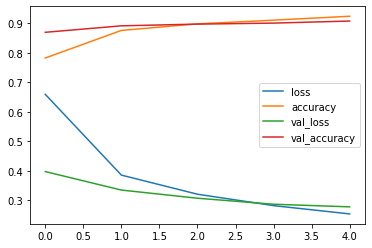

In [36]:
pd.DataFrame(history_model_1.history).plot()

### Model_2 : Efficient b7 (Augmentation)  

In [37]:
# Get the base model 
base_model = tf.keras.applications.EfficientNetB7(include_top=False) # False coz we want our own custmized output

# Freese the model 
base_model.trainable = False 

# Inputs for base_model
inputs = tf.keras.layers.Input(shape=(224,224,3) , name="input_layer")

# Augmentation layer 
x = Augmented_layer(inputs)

# Pass augmented data to model and dont train it 
x = base_model(x , training=False)

# Global Average pooling 2D 
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling_2D")(x)

# Output layer 
outputs = tf.keras.layers.Dense(5 ,activation="softmax" , name="output_layer")(x)

# Create the model 
model_2 = tf.keras.Model(inputs , outputs , name ="Efficient_b7_model_No_Aug")

# Compile the model 
model_2.compile(loss ="categorical_crossentropy",
                optimizer =tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model 
history_model_2 = model_2.fit(train_data, 
                               epochs=initial_epochs,
                               steps_per_epoch=len(train_data),
                               validation_data =test_data,
                               validation_steps=len(test_data),
                               callbacks=[create_tensorboard_callback("tensorboard", "Efficient_b7_model_Aug"),
                                          checkpoint_callback])

Saving tensorboard log files to tensorboard/Efficient_b7_model_Aug/20220421-055630
Epoch 1/5
108/108 [==============================] - ETA: 0s - loss: 0.7460 - accuracy: 0.7332
Epoch 1: val_loss did not improve from 0.27732
108/108 [==============================] - 133s 1s/step - loss: 0.7460 - accuracy: 0.7332 - val_loss: 0.4454 - val_accuracy: 0.8416
Epoch 2/5
108/108 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.8355
Epoch 2: val_loss did not improve from 0.27732
108/108 [==============================] - 90s 829ms/step - loss: 0.4826 - accuracy: 0.8355 - val_loss: 0.3756 - val_accuracy: 0.8636
Epoch 3/5
108/108 [==============================] - ETA: 0s - loss: 0.4114 - accuracy: 0.8607
Epoch 3: val_loss did not improve from 0.27732
108/108 [==============================] - 90s 832ms/step - loss: 0.4114 - accuracy: 0.8607 - val_loss: 0.3392 - val_accuracy: 0.8798
Epoch 4/5
108/108 [==============================] - ETA: 0s - loss: 0.3797 - accuracy: 0.8

In [38]:
model_2.evaluate(test_data)

28/28 [==============================] - 10s 357ms/step - loss: 0.3134 - accuracy: 0.8867


[0.3133997619152069, 0.886705219745636]

In [39]:
model_2.save("/content/drive/MyDrive/Saved_models/flower_classfication_models/Efficient_b7_with_Aug.h5")

In [40]:
loaded_model_2 = tf.keras.models.load_model("/content/drive/MyDrive/Saved_models/flower_classfication_models/Efficient_b7_with_Aug.h5")

In [41]:
loaded_model_2.evaluate(test_data)

28/28 [==============================] - 14s 357ms/step - loss: 0.3134 - accuracy: 0.8867


[0.3133997619152069, 0.886705219745636]

## Load and test on custom data 

In [42]:
test_model = tf.keras.models.load_model("/content/drive/MyDrive/Saved_models/flower_classfication_models/Efficient_b7")

In [43]:
pred = test_model.predict(test_data)

In [44]:
pred 

array([[9.0332943e-01, 6.8174899e-02, 1.4808774e-02, 4.1766679e-03,
        9.5102368e-03],
       [5.1229054e-01, 2.7125317e-01, 1.7573243e-02, 3.3858120e-02,
        1.6502488e-01],
       [9.8616982e-01, 7.4903374e-03, 1.0953273e-03, 4.8459130e-03,
        3.9851299e-04],
       ...,
       [9.0023480e-02, 1.8894114e-01, 5.3636465e-02, 1.7116977e-01,
        4.9622914e-01],
       [2.5864298e-02, 2.8358125e-03, 1.8569359e-01, 4.9911608e-04,
        7.8510720e-01],
       [8.9364462e-03, 9.3852989e-03, 3.2490440e-02, 6.0528988e-01,
        3.4389794e-01]], dtype=float32)

In [45]:
len(pred)

865

In [46]:
pred.shape

(865, 5)

In [47]:
pred_classes = pred.argmax(axis=1)
class_names[pred_classes[-1]]

'sunflower'

In [48]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [49]:
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [50]:
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [51]:
test_dir

'/content/flower_split/val'

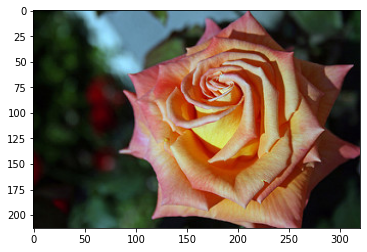

In [52]:
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename
plt.imshow(mpimg.imread(filepath))

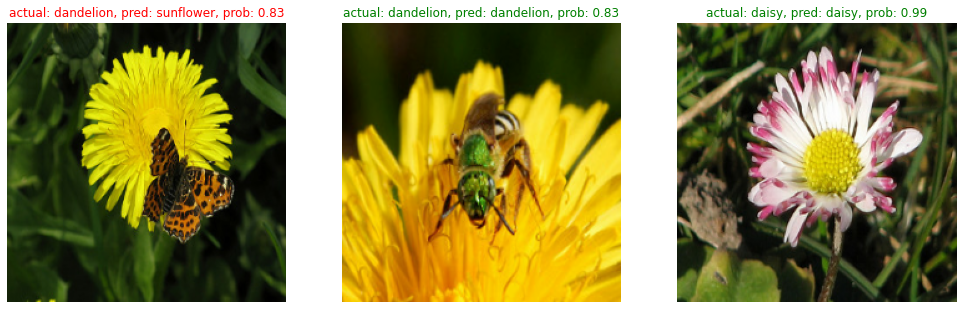

In [55]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred = test_model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred.max():.2f}", c=title_color)
  plt.axis(False);